In [1]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
! ls ../Feb16_2017

DYJetsToLL_Pt-100To250                  TTToHadronic
DYJetsToLL_Pt-250To400                  TTToSemiLeptonic
DYJetsToLL_Pt-400To650                  VBFHToTauTau
DYJetsToLL_Pt-50To100                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
DYJetsToLL_Pt-650ToInf                  WJetsToLNu_HT-100To200
GluGluHToTauTau                         WJetsToLNu_HT-1200To2500
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-200To400
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-2500ToInf
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-400To600
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-600To800
HZJ_HToWW_M-125                         WJetsToLNu_HT-70To100
QCD_Pt_1000to1400                       WJetsToLNu_HT-800To1200
QCD_Pt_1400to1800                       WJetsToQQ_HT-200to400
QCD_Pt_170to300                         WJetsToQQ_HT-400to600
QCD_Pt_1800to2400                       WJetsToQQ_HT-600to800
QCD_Pt_2400to3200                       WJetsToQQ_HT-800toInf
QCD

# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- saves the combined dataframe under `events[ch][sample]`

In [3]:
combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

In [4]:
samples_dir = "../Feb16_2017"
samples = os.listdir(samples_dir)

channels = ["mu", "ele"]

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
}

In [5]:
def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den

# s/b

In [6]:
pd.options.mode.chained_assignment = None

presel = {
    "mu": {
        "preselection": "( (fj_pt > 0) )",
        "preselection + bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",                
        "preselection + isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
        "preselection + mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",  
        "preselection + all of the above": "( (fj_bjets_ophem<0.3040) & ( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) ) & ( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) ))",
    },
}


# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]
tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]

sigs = {
    "ele": hwwev,
    "mu": hwwmv,
}
bkgs = {
    "ele": tope+qcd,
    "mu": topm+qcd,
}

ch = "mu"
is_data = False

events_dict = {}
for selection in presel[ch]:
    events_dict[selection] = {}

new_sig = [s.replace("PN","ParT_all_nodes") for s in sigs[ch]]
new_bkg = [b.replace("PN","ParT_all_nodes") for b in bkgs[ch]]

# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)[ch]["2017"]

for sample in samples:

    ### get a combined label to combine samples of the same process
    for key in combine_samples:
        if key in sample:
            sample_to_use = combine_samples[key]
            break
        else:
            sample_to_use = sample

    print(f"Finding {sample} samples and should combine them under {sample_to_use}")

    out_files = f"{samples_dir}/{sample}/outfiles/"
    parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
    pkl_files = glob.glob(f"{out_files}/*.pkl")

    if not parquet_files:
        print(f"No parquet file for {sample}")
        continue                

    data = pd.read_parquet(parquet_files)
    empty = len(data) == 0
    if empty:
        continue
    
    # get event_weight
    print(f"---> Retrieving event weight.")                
    event_weight = utils.get_xsecweight(pkl_files, "2017", sample, is_data, luminosity)
    for w in weights[ch]:
        if w not in data.keys():
            print(f"{w} weight is not stored in parquet")
            continue
        event_weight *= data[w]

    data["event_weight"] = event_weight
    
    print(f"---> We have {len(data)} events.")        
    # apply selection
    for selection in presel[ch]:
        data1 = data.query(presel[ch][selection])  
        print(f"---> Applied {selection}... Only {len(data1)} events survived.")        

        # add score 
        data1["score"] = disc_score(data1,new_sig,new_bkg)

        ### specefy columns to keep
        columns_ = ["score", "fj_ParT_all_nodes_mass", "lep_fj_m", "event_weight"]
        
        # fill the big dataframe
        if sample_to_use not in events_dict[selection]:
            events_dict[selection][sample_to_use] = data1[columns_]
        else:
            events_dict[selection][sample_to_use] = pd.concat([events_dict[selection][sample_to_use], data1[columns_]])

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Retrieving event weight.
---> We have 964 events.
---> Applied preselection... Only 964 events survived.
---> Applied preselection + bjet_ophem... Only 743 events survived.
---> Applied preselection + isolation... Only 949 events survived.
---> Applied preselection + mini-isolation... Only 946 events survived.
---> Applied preselection + all of the above... Only 714 events survived.
Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Retrieving event weight.
---> We have 9908 events.
---> Applied preselection... Only 9908 events survived.
---> Applied preselection + bjet_ophem... Only 8778 events survived.
---> Applied preselection + isolation... Only 9814 events survived.
---> Applied preselection + mini-isolation... Only 9705 events survived.
---> Applied preselection + all of the above... Only 8516 events survived.
Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and

---> Retrieving event weight.
---> We have 89 events.
---> Applied preselection... Only 89 events survived.
---> Applied preselection + bjet_ophem... Only 40 events survived.
---> Applied preselection + isolation... Only 89 events survived.
---> Applied preselection + mini-isolation... Only 88 events survived.
---> Applied preselection + all of the above... Only 40 events survived.
Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
---> Retrieving event weight.
weight_vjets_nominal weight is not stored in parquet
---> We have 36205 events.
---> Applied preselection... Only 36205 events survived.
---> Applied preselection + bjet_ophem... Only 9755 events survived.
---> Applied preselection + isolation... Only 35307 events survived.
---> Applied preselection + mini-isolation... Only 34860 events survived.
---> Applied preselection + all of the above... Only 9085 events survived.
Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
-

---> Retrieving event weight.
---> We have 164671 events.
---> Applied preselection... Only 164671 events survived.
---> Applied preselection + bjet_ophem... Only 148361 events survived.
---> Applied preselection + isolation... Only 160470 events survived.
---> Applied preselection + mini-isolation... Only 159055 events survived.
---> Applied preselection + all of the above... Only 139534 events survived.
Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
---> Retrieving event weight.
---> We have 7609 events.
---> Applied preselection... Only 7609 events survived.
---> Applied preselection + bjet_ophem... Only 6977 events survived.
---> Applied preselection + isolation... Only 5847 events survived.
---> Applied preselection + mini-isolation... Only 2091 events survived.
---> Applied preselection + all of the above... Only 300 events survived.
Finding GluGluHToWWToLNuQQ samples and should combine them under Diboson
---> Retrieving event weight.
weight_vjets_nomina

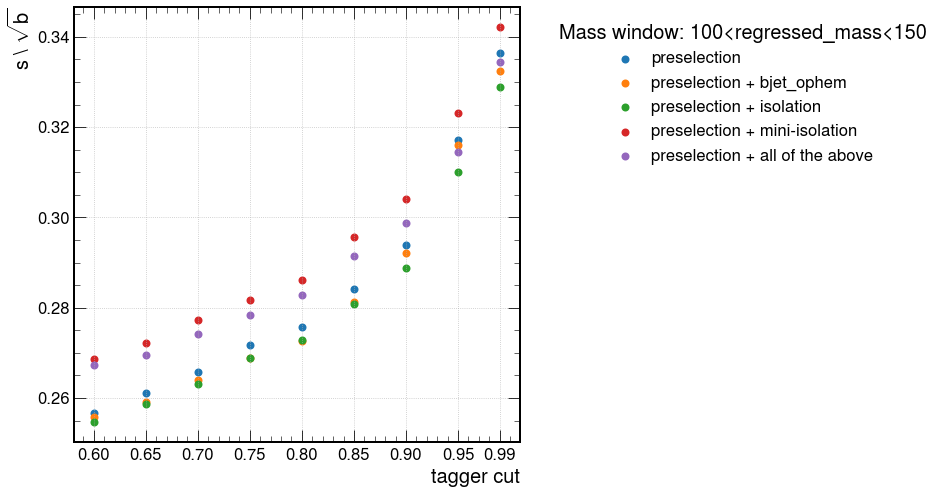

In [9]:
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,8))
ax.grid()

for selection in events_dict:

    cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    
    s = [0]*len(cuts)
    b = [0]*len(cuts)

    for sample in events_dict[selection]:
        ev_weight = events_dict[selection][sample]["event_weight"]
        score = events_dict[selection][sample]["score"]

        regressed_mass = events_dict[selection][sample]["fj_ParT_all_nodes_mass"]
        mass_window = (regressed_mass>100) & (regressed_mass<150)

        for i, cut in enumerate(cuts):
            score_cut = (score > cut)
            if sample == "HWW":
                s[i] += ev_weight[mass_window & score_cut].sum()     
            else:
                b[i] += ev_weight[mass_window & score_cut].sum()
    
    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(cuts, ss/np.sqrt(bb) , linewidth=2.0, label=selection)

ax.set_xticks(cuts)
ax.set_xlabel("tagger cut")
ax.set_ylabel(r"s \ $\sqrt{b}$")
ax.legend(title="Mass window: 100<regressed_mass<150", bbox_to_anchor=(1.05, 1), loc="upper left",);

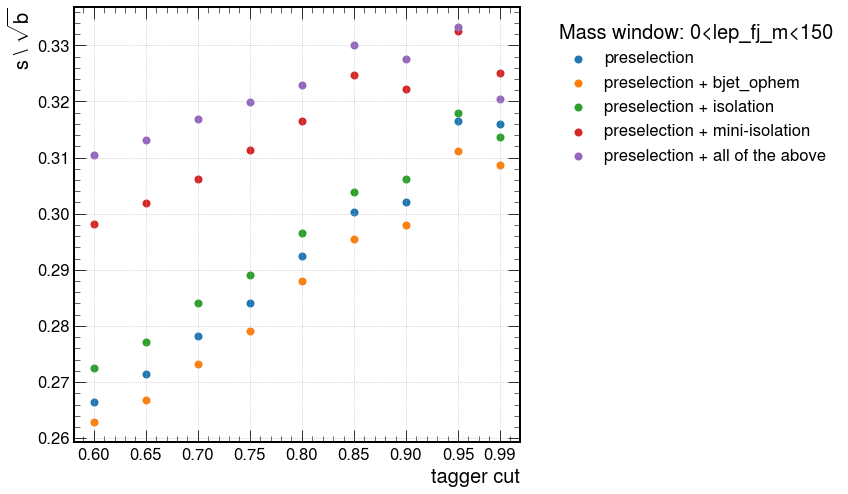

In [10]:
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,8))
ax.grid()

for selection in events_dict:

    cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    
    s = [0]*len(cuts)
    b = [0]*len(cuts)

    for sample in events_dict[selection].keys():
        ev_weight = events_dict[selection][sample]["event_weight"]
        score = events_dict[selection][sample]["score"]
        
        lep_fj_m = events_dict[selection][sample]["lep_fj_m"]
        mass_window = (lep_fj_m>0) & (lep_fj_m<150)
        
        for i, cut in enumerate(cuts):
            score_cut = (score > cut)
            if sample == "HWW":
                s[i] += ev_weight[mass_window & score_cut].sum()     
            else:
                b[i] += ev_weight[mass_window & score_cut].sum()
    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(cuts, ss/np.sqrt(bb) , linewidth=2.0, label=selection)

ax.set_xticks(cuts)
ax.set_xlabel("tagger cut")
ax.set_ylabel(r"s \ $\sqrt{b}$")
ax.legend(title="Mass window: 0<lep_fj_m<150", bbox_to_anchor=(1.05, 1), loc="upper left",);